**Определение уровня стресса по физиологическим показателям (Stress Detection)**

Ссылка на набор данных: https://www.kaggle.com/code/dheerov/stress-detection/input

Описание данных:

**snoring range** (диапазон храпа) - громкость храпа в дБ (dB), значения дробные с точностью до сотых, количественный, непрерывный;

**respiration rate** (частота дыхания) - количество дыхательных циклов в минуту (breaths per minute, bpm), значения дробные с точностью до сотых, количественный, непрерывный;

**body tempreture** (температура тела) - температура тела в градусах по Фаренгейту (°F), значения дробные с точностью до сотых, количественный, непрерывный;

**limb movement** (движение конечностей) - количество движений конечностей в час (movements per hour), значения дробные с точностью до сотых, количественный, непрерывный;

**blood oxygen** (сатурация) - доля насыщенного кислородом гемоглобина в крови относительно общего гемоглобина в крови (%), значения дробные с точностью до сотых, количественный, непрерывный;

**eye movement** (движение глаз) - количество движений глаз в час (movements per hour), значения дробные с точностью до сотых, количественный, непрерывный;

**hours of sleep** (количество часов сна) - часы сна (Hours), значения дробные с точностью до сотых, количественный, непрерывный;

**heart rate** (частота сердечных сокращений) - средняя частота сердечных сокращений в минуту (beats per minute, bpm), значения дробные с точностью до сотых, количественный, непрерывный;

**Stress levels** (уровень стресса) - уровень стресса по шкале от 0 до 4 (Stress Level), значения целые, категориальный.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ks_2samp, levene, kruskal, mannwhitneyu, probplot
from itertools import combinations
import statsmodels.stats.multitest as smt

In [2]:
# Настройка параметров отображения для вывода всех строк
pd.set_option('display.max_rows', None)

In [3]:
# Настройка параметров отображения для вывода в обычном формате
pd.options.display.float_format = '{:.6f}'.format

В качестве первой гипотезы распределения признаков на нормальность, т.к. это поможет нам в дальнейших тестах, ведь многие статистические тесты, например ANOVA и t-test требуют нормальности распределения, а также на этапе выбора модели на последнем этапе нашего исследования нам было бы полезно знать - с каким распределением мы имеем дело.

Гипотеза 1:
H₀: Данные распределены нормально.
H₁: Данные не распределены нормально.
(для каждого признака отдельно)

In [ ]:
# Визуальная оценка распределений

sns.set_style("whitegrid")

for i, col in enumerate(numeric):
    plt.figure(figsize=(12, 4))
    
    # Q-Q plot
    plt.subplot(1, 2, 1)
    probplot(stressed_df[col], dist='norm', plot=plt)
    plt.title(f"Q-Q plot для признака: '{col}'", fontsize=10)

    # KDE
    plt.subplot(1, 2, 2)
    sns.histplot(stressed_df[col], kde=True)
    plt.title(f"Гистограмма для признака: '{col}'", fontsize=10)

    plt.show()

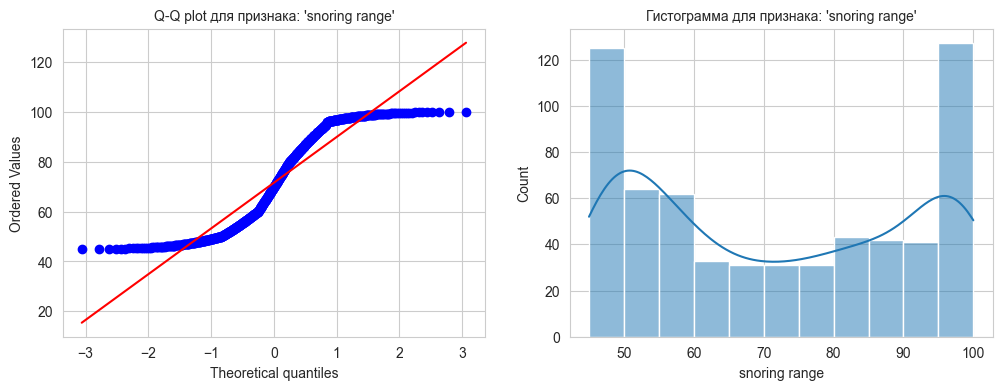

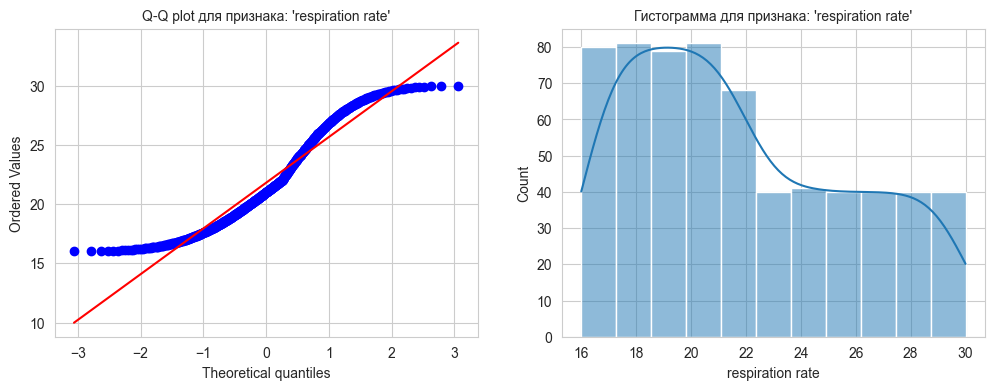

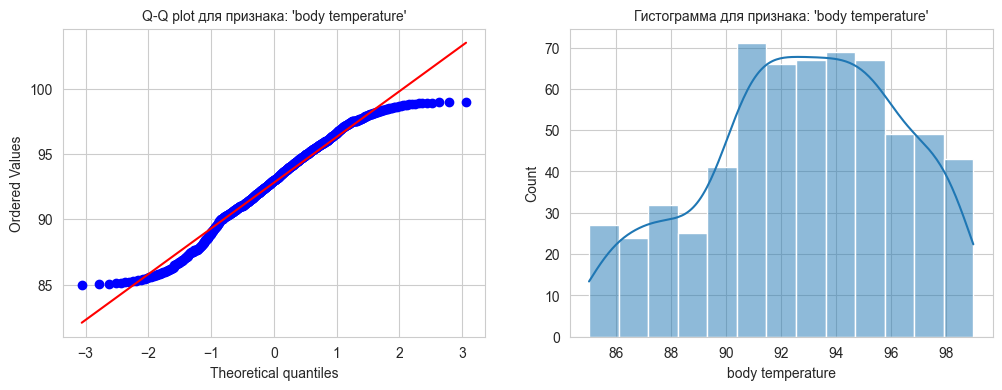

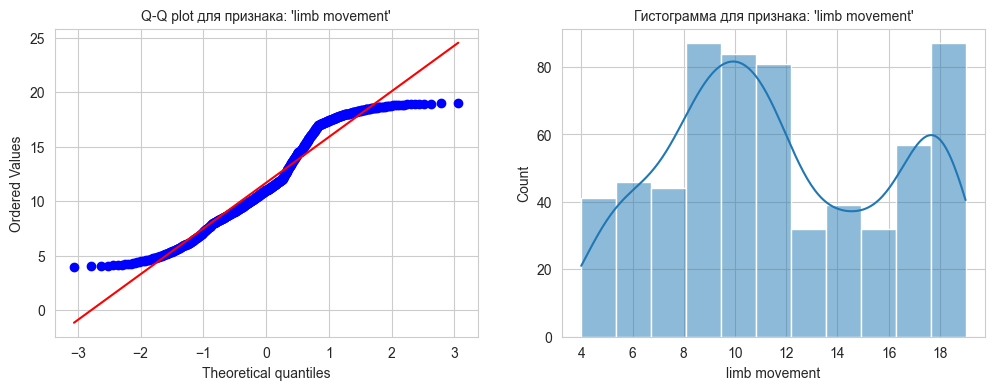

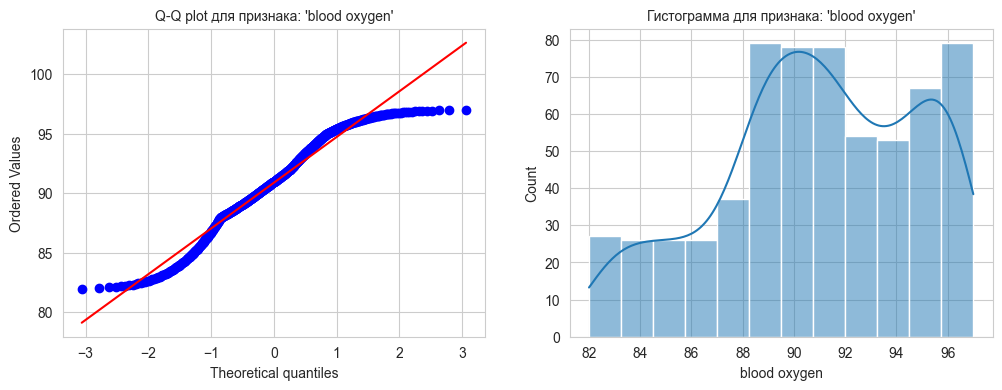

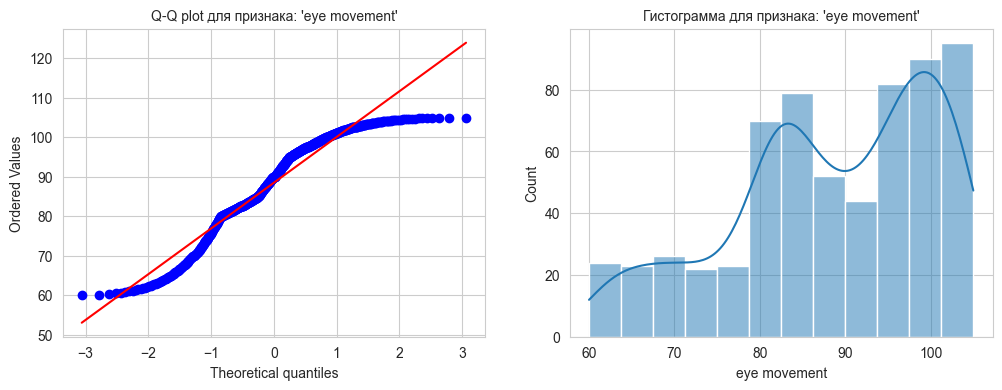

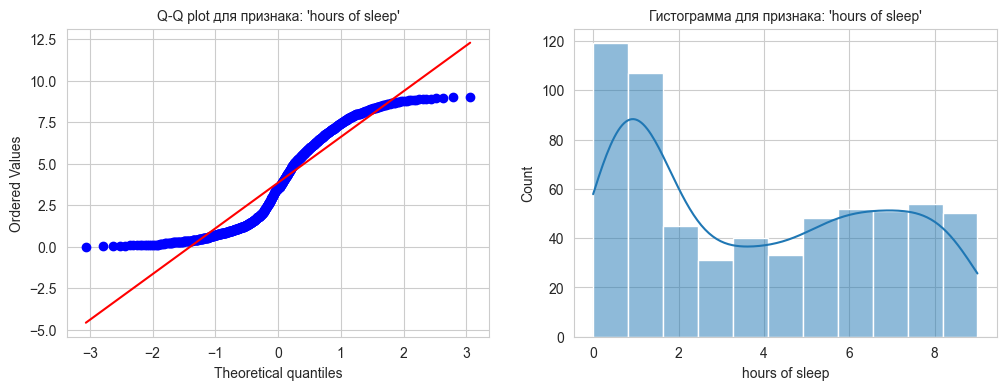

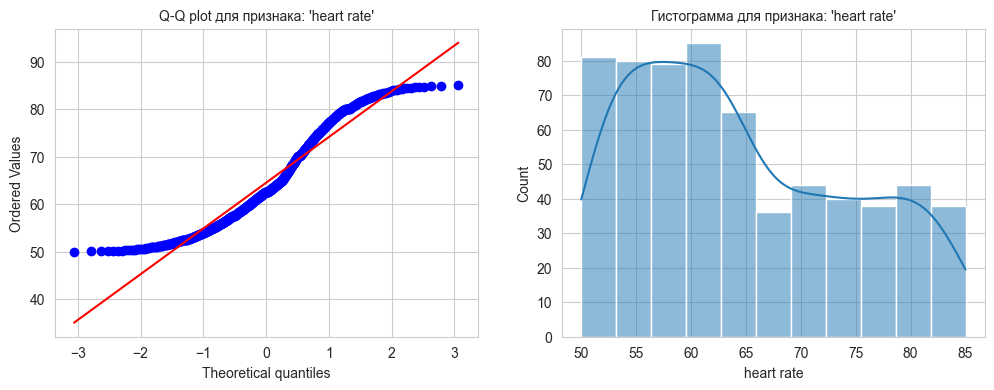

На нормальное распределение не очень похоже, убедимся на тестах.

In [ ]:
import warnings
from scipy.stats import shapiro, lognorm, expon, gamma, beta, skewnorm, kstest, anderson

warnings.filterwarnings('ignore') # Крайне малые величины в проверке распределения

def anderson_p(stat, critical_v, sign_lvl):
    """Апроксимируем p-value для теста Андерсона-Дарлинга"""
    for i in range(len(critical_v)):
        if stat < critical_v[i]:
            return sign_lvl[i] / 100
    # Если статистика превышает все критические значения из теста
    return sign_lvl[-1] / 100

# Словарь 'объектов' распределений, понадобится чуть позже
distr_funcs = {
    'lognorm': lognorm,
    'expon': expon,
    'gamma': gamma,
    'beta': beta,
    'skewnorm': skewnorm,
}

distr_names = {
    'lognorm': 'Логнормальное',
    'expon': 'Экспоненциальное', 
    'gamma': 'Гамма',
    'beta': 'Бета',
    'skewnorm': 'Accиметричное нормальное',
}

# Применяем метод Шапиро-Уилка к каждому признаку
for col in numeric:
    # Тест Шапиро-Уилка для проверки нормальности
    shapiro_stat, shapiro_p = shapiro(stressed_df[col])
    anderson_res = anderson(stressed_df[col])

    # Апроксимация для Андерсона-Дарлинга
    and_dar_p = anderson_p(anderson_res.statistic, anderson_res.critical_values, anderson_res.significance_level)

    # Результат
    print(f"\n---Проверка признака '{col}'---")
    print(f"Метод Шапиро-Уилка, p-value = {shapiro_p:.20f}")
    print(f"Метод Андерсона-Дарлинга, p-value ~ {and_dar_p:.20f}")
    if shapiro_p > 0.05 or and_dar_p > 0.05:
        print(f"Подтверждаем Нулевую гипотезу для '{col}', тк (p > 0.05);")
    else:
        print(f"Принимаем Альтернативную гипотезу для '{col}', тк (p ≤ 0.05)")

        # Инициализирую результирующие переменные
        res, best_p = None, -np.inf
        for d_name, d_func in distr_funcs.items():
            temp = d_func.fit(stressed_df[col])

            # Тест Колмогорова-Смирнова
            D, p = kstest(stressed_df[col], d_name, args=temp)
            if p > best_p:
                best_p = p
                res = d_name
        if best_p > 0.05:
            print(f"Подобрали '{distr_names[res]}' распределение для {col}, тк (p={best_p:.5f} > 0.05);")
        else:
            print(f"В ходе проведенных тестов не удалось подобрать распределение для {col};")

---Проверка признака 'snoring range'---
Метод Шапиро-Уилка, p-value = 0.00000000000000000001
Метод Андерсона-Дарлинга, p-value ~ 0.01000000000000000021
Принимаем Альтернативную гипотезу для 'snoring range', тк (p ≤ 0.05)
В ходе проведенных тестов не удалось подобрать распределение для snoring range;

---Проверка признака 'respiration rate'---
Метод Шапиро-Уилка, p-value = 0.00000000000000167560
Метод Андерсона-Дарлинга, p-value ~ 0.01000000000000000021
Принимаем Альтернативную гипотезу для 'respiration rate', тк (p ≤ 0.05)
Подобрали 'Accиметричное нормальное' распределение для respiration rate, тк (p=0.08104 > 0.05);

---Проверка признака 'body temperature'---
Метод Шапиро-Уилка, p-value = 0.00000000703973235261
Метод Андерсона-Дарлинга, p-value ~ 0.01000000000000000021
Принимаем Альтернативную гипотезу для 'body temperature', тк (p ≤ 0.05)
Подобрали 'Accиметричное нормальное' распределение для body temperature, тк (p=0.37757 > 0.05);

---Проверка признака 'limb movement'---
Метод Шапиро-Уилка, p-value = 0.00000000000003498726
Метод Андерсона-Дарлинга, p-value ~ 0.01000000000000000021
Принимаем Альтернативную гипотезу для 'limb movement', тк (p ≤ 0.05)
В ходе проведенных тестов не удалось подобрать распределение для limb movement;

---Проверка признака 'blood oxygen'---
Метод Шапиро-Уилка, p-value = 0.00000000001455512967
Метод Андерсона-Дарлинга, p-value ~ 0.01000000000000000021
Принимаем Альтернативную гипотезу для 'blood oxygen', тк (p ≤ 0.05)
В ходе проведенных тестов не удалось подобрать распределение для blood oxygen;

---Проверка признака 'eye movement'---
Метод Шапиро-Уилка, p-value = 0.00000000000000132044
Метод Андерсона-Дарлинга, p-value ~ 0.01000000000000000021
Принимаем Альтернативную гипотезу для 'eye movement', тк (p ≤ 0.05)
Подобрали 'Бета' распределение для eye movement, тк (p=0.10449 > 0.05);

---Проверка признака 'hours of sleep'---
Метод Шапиро-Уилка, p-value = 0.00000000000000000014
Метод Андерсона-Дарлинга, p-value ~ 0.01000000000000000021
Принимаем Альтернативную гипотезу для 'hours of sleep', тк (p ≤ 0.05)
В ходе проведенных тестов не удалось подобрать распределение для hours of sleep;

---Проверка признака 'heart rate'---
Метод Шапиро-Уилка, p-value = 0.00000000000000151603
Метод Андерсона-Дарлинга, p-value ~ 0.01000000000000000021
Принимаем Альтернативную гипотезу для 'heart rate', тк (p ≤ 0.05)
Подобрали 'Accиметричное нормальное' распределение для heart rate, тк (p=0.05849 > 0.05);

Для всех признаков принимаем альтернативную гипотезу, не удалось привязаться к конкретным видам распределения для "snoring range", "limb movement", "blood oxygen", "hours of sleep". Для дальнейших тестов нужно использовать непараметрические методы.

В качестве второй гипотезы проверим характер распределений внутри классов для каждого признака, это позволит нам лучше понять структуру наших данных, отличаются ли классы друг от друга и какими методами можно пользоваться для тестирования.

Проверим:

Нормальное ли распределение в пределах каждого класса.
Нулевая гипотеза: Распределение нормально.
Альтернативная гипотеза: Распределение не нормально.
(для каждого признака отдельно)

Сравним пары распределений одного признака между классами.
Нулевая гипотеза: Распределения одинаковы.
Альтернативная гипотеза: Распределения отличаются.
(для каждого признака отдельно)

Проверим равенство дисперсий - анализ разброса между классами.
Нулевая гипотеза: Дисперсии равны.
Альтернативная гипотеза: Дисперсии не равны.
(для каждого признака отдельно)

In [4]:
data = pd.read_csv(r'C:\Users\ela96\ABD-PRJ-25-29\data_filled.csv')
data.sample(10)

,snoring range,respiration rate,body temperature,limb movement,blood oxygen,eye movement,hours of sleep,heart rate,Stress Levels
598,99.104000,29.104000,88.880000,18.552000,86.656000,103.880000,0.307304,82.760000,4
212,45.480000,16.192000,96.288000,36.230000,95.192000,61.920000,7.192000,50.480000,0
166,46.800000,16.720000,97.080000,5.440000,95.720000,67.200000,7.720000,51.800000,0
162,55.760000,19.152000,95.141333,9.152000,93.728000,82.880000,6.152000,57.880000,1
87,51.600000,18.320000,94.320000,8.320000,92.480000,80.800000,5.320000,55.800000,1
85,54.880000,18.976000,94.976000,8.976000,93.464000,82.440000,5.976000,57.440000,1
620,97.024000,27.024000,86.280000,17.512000,83.536000,101.280000,1.008384,77.560000,4
141,81.440000,22.384000,90.192000,12.480000,88.192000,95.453333,0.192000,65.960000,3
555,87.080000,23.888000,90.944000,14.360000,88.944000,97.360000,0.944000,69.720000,3
242,84.440000,23.184000,90.592000,13.480000,88.592000,96.480000,0.581333,67.960000,3


In [5]:
data.shape

(630, 9)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 630 entries, 0 to 629
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   snoring range     630 non-null    float64
 1   respiration rate  630 non-null    float64
 2   body temperature  630 non-null    float64
 3   limb movement     630 non-null    float64
 4   blood oxygen      630 non-null    float64
 5   eye movement      630 non-null    float64
 6   hours of sleep    630 non-null    float64
 7   heart rate        630 non-null    float64
 8   Stress Levels     630 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 44.4 KB


In [10]:
def analyze_feature_distribution(data, feature, class_col='Stress Levels'):
    print(f"\n=== Анализ признака: {feature} ===")

    classes = sorted(data[class_col].dropna().unique())

    # 1. Гистограммы / KDE
    plt.figure(figsize=(12, 6))
    for cls in classes:
        subset = data[data[class_col] == cls][feature].dropna()
        sns.kdeplot(subset, label=f"Class {cls}", fill=True, alpha=0.3)
    plt.title(f"Распределение признака '{feature}' по классам")
    plt.xlabel(feature)
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Тест Шапиро–Уилка (нормальность по классам)
    print("\n> Тест Шапиро–Уилка (нормальность по классам):")
    for cls in classes:
        values = data[data[class_col] == cls][feature].dropna()
        if len(values) >= 3:
            stat, p = shapiro(values)
            result = "Нормальное" if p > 0.05 else "Не нормальное"
            print(f"  Class {cls}: p = {p:.4f} → {result}")
        else:
            print(f"  Class {cls}: недостаточно данных")

    # 3. Тест Колмогорова–Смирнова (между классами)
    print("\n> Тест Колмогорова–Смирнова (сравнение распределений между классами):")
    for cls1, cls2 in combinations(classes, 2):
        v1 = data[data[class_col] == cls1][feature].dropna()
        v2 = data[data[class_col] == cls2][feature].dropna()
        if len(v1) >= 2 and len(v2) >= 2:
            stat, p = ks_2samp(v1, v2)
            result = "Разные" if p < 0.05 else "Похожие"
            print(f"  Class {cls1} vs {cls2}: p = {p:.4f} → {result}")
        else:
            print(f"  Class {cls1} vs {cls2}: недостаточно данных")

   # 4. Тест Левена (равенство дисперсий) с попарными сравнениями
    print("\n> Тест Левена (проверка равенства дисперсий):")
    groups = [data[data[class_col] == cls][feature].dropna() for cls in classes]
    
    if all(len(g) >= 2 for g in groups):
        # Общий тест для всех групп
        stat, p = levene(*groups)
        print(f"  Общий тест: p = {p:.4f} → {'Дисперсии равны' if p > 0.05 else 'Дисперсии различаются'}")
        
        # Попарные сравнения с поправкой Бонферрони
        if p < 0.05 and len(classes) > 2:
            print("\n  Попарные сравнения дисперсий:")
            p_values = []
            pairs = []
            for (cls1, cls2) in combinations(classes, 2):
                g1 = data[data[class_col] == cls1][feature].dropna()
                g2 = data[data[class_col] == cls2][feature].dropna()
                _, p_val = levene(g1, g2)
                p_values.append(p_val)
                pairs.append(f"{cls1} vs {cls2}")
            
            # Применяем поправку Бонферрони
            reject, p_corrected, _, _ = smt.multipletests(p_values, alpha=0.05, method='bonferroni')
            
            for pair, p_orig, p_adj, rej in zip(pairs, p_values, p_corrected, reject):
                result = "Различаются" if rej else "Не различаются"
                print(f"  {pair}: p = {p_orig:.4f} (скорр. = {p_adj:.4f}) → {result}")
    else:
        print("  Недостаточно данных для Levene-теста")

    # 5. Критерий Крускала-Уоллиса с пост-хок тестами
    print("\n> Критерий Крускала-Уоллиса (непараметрический ANOVA):")
    if all(len(g) >= 3 for g in groups):
        # Общий тест
        h_stat, p = kruskal(*groups)
        print(f"  Общий тест: p = {p:.4f} → {'Есть различия' if p < 0.05 else 'Нет различий'}")
        
        # Попарные сравнения при наличии различий
        if p < 0.05 and len(classes) > 2:
            print("\n  Попарные сравнения (U-тест Манна-Уитни с поправкой Бонферрони):")
            p_values = []
            pairs = []
            for (cls1, cls2) in combinations(classes, 2):
                g1 = data[data[class_col] == cls1][feature].dropna()
                g2 = data[data[class_col] == cls2][feature].dropna()
                _, p_val = mannwhitneyu(g1, g2, alternative='two-sided')
                p_values.append(p_val)
                pairs.append(f"{cls1} vs {cls2}")
            
            # Применяем поправку Бонферрони
            reject, p_corrected, _, _ = smt.multipletests(p_values, alpha=0.05, method='bonferroni')
            
            for pair, p_orig, p_adj, rej in zip(pairs, p_values, p_corrected, reject):
                result = "Различаются" if rej else "Не различаются"
                print(f"  {pair}: p = {p_orig:.4f} (скорр. = {p_adj:.4f}) → {result}")
                
    elif len(classes) == 2:  # Для двух групп сразу выполняем U-тест
        g1 = data[data[class_col] == classes[0]][feature].dropna()
        g2 = data[data[class_col] == classes[1]][feature].dropna()
        _, p = mannwhitneyu(g1, g2)
        print(f"  U-тест Манна-Уитни: p = {p:.4f} → {'Различаются' if p < 0.05 else 'Не различаются'}")
    else:
        print("  Недостаточно данных для теста")

In [8]:
features = ['respiration rate', 'body temperature', 'limb movement', 
            'blood oxygen', 'eye movement', 'hours of sleep', 'heart rate']


=== Анализ признака: respiration rate ===


C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

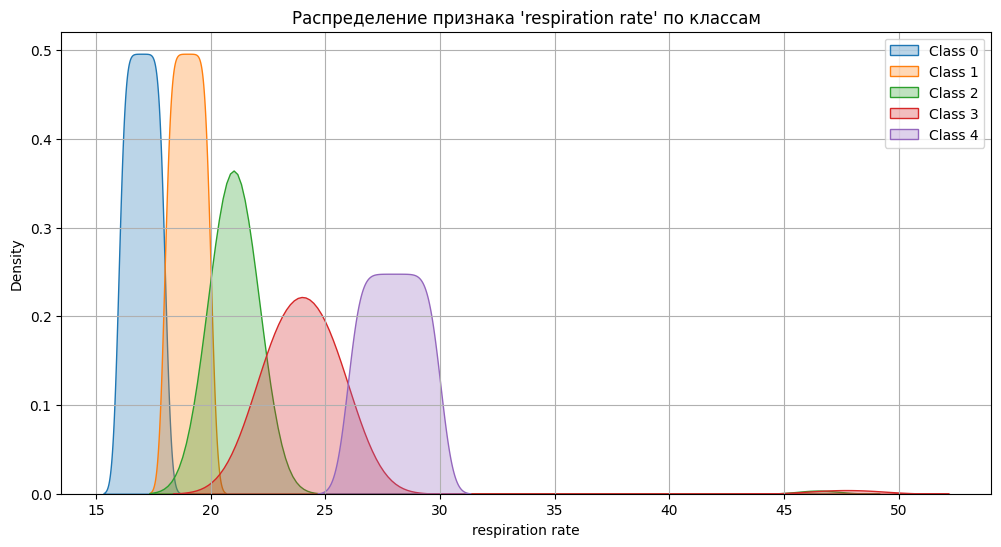


> Тест Шапиро–Уилка (нормальность по классам):
  Class 0: p = 0.0003 → Не нормальное
  Class 1: p = 0.0003 → Не нормальное
  Class 2: p = 0.0000 → Не нормальное
  Class 3: p = 0.0000 → Не нормальное
  Class 4: p = 0.0003 → Не нормальное

> Тест Колмогорова–Смирнова (сравнение распределений между классами):
  Class 0 vs 1: p = 0.0000 → Разные
  Class 0 vs 2: p = 0.0000 → Разные
  Class 0 vs 3: p = 0.0000 → Разные
  Class 0 vs 4: p = 0.0000 → Разные
  Class 1 vs 2: p = 0.0000 → Разные
  Class 1 vs 3: p = 0.0000 → Разные
  Class 1 vs 4: p = 0.0000 → Разные
  Class 2 vs 3: p = 0.0000 → Разные
  Class 2 vs 4: p = 0.0000 → Разные
  Class 3 vs 4: p = 0.0000 → Разные

> Тест Левена (проверка равенства дисперсий):
  Общий тест: p = 0.0001 → Дисперсии различаются

  Попарные сравнения дисперсий:
  0 vs 1: p = 1.0000 (скорр. = 1.0000) → Не различаются
  0 vs 2: p = 0.3174 (скорр. = 1.0000) → Не различаются
  0 vs 3: p = 0.0012 (скорр. = 0.0117) → Различаются
  0 vs 4: p = 0.0000 (скорр. = 0.0000

C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

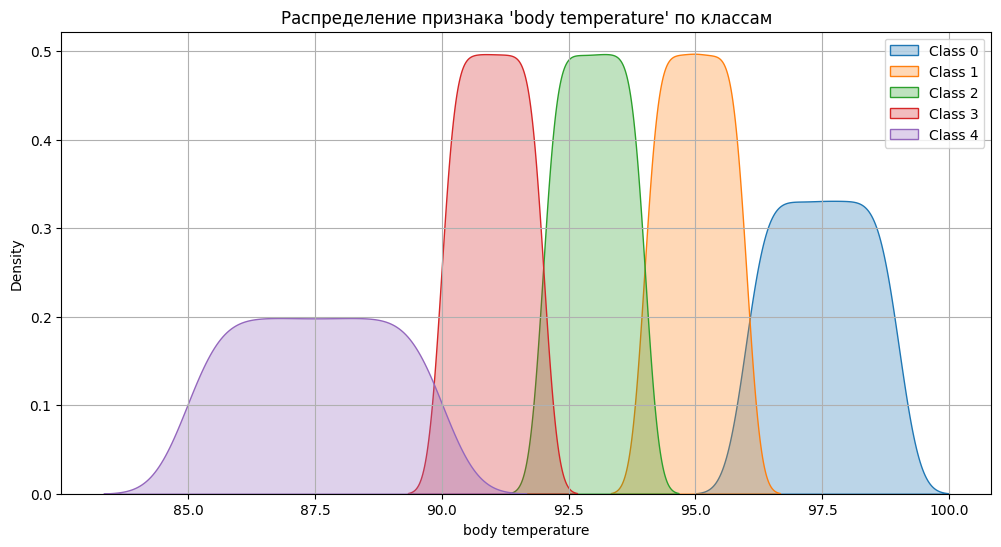


> Тест Шапиро–Уилка (нормальность по классам):
  Class 0: p = 0.0003 → Не нормальное
  Class 1: p = 0.0003 → Не нормальное
  Class 2: p = 0.0003 → Не нормальное
  Class 3: p = 0.0003 → Не нормальное
  Class 4: p = 0.0003 → Не нормальное

> Тест Колмогорова–Смирнова (сравнение распределений между классами):
  Class 0 vs 1: p = 0.0000 → Разные
  Class 0 vs 2: p = 0.0000 → Разные
  Class 0 vs 3: p = 0.0000 → Разные
  Class 0 vs 4: p = 0.0000 → Разные
  Class 1 vs 2: p = 0.0000 → Разные
  Class 1 vs 3: p = 0.0000 → Разные
  Class 1 vs 4: p = 0.0000 → Разные
  Class 2 vs 3: p = 0.0000 → Разные
  Class 2 vs 4: p = 0.0000 → Разные
  Class 3 vs 4: p = 0.0000 → Разные

> Тест Левена (проверка равенства дисперсий):
  Общий тест: p = 0.0000 → Дисперсии различаются

  Попарные сравнения дисперсий:
  0 vs 1: p = 0.0000 (скорр. = 0.0000) → Различаются
  0 vs 2: p = 0.0000 (скорр. = 0.0000) → Различаются
  0 vs 3: p = 0.0000 (скорр. = 0.0000) → Различаются
  0 vs 4: p = 0.0000 (скорр. = 0.0000) → Ра

C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

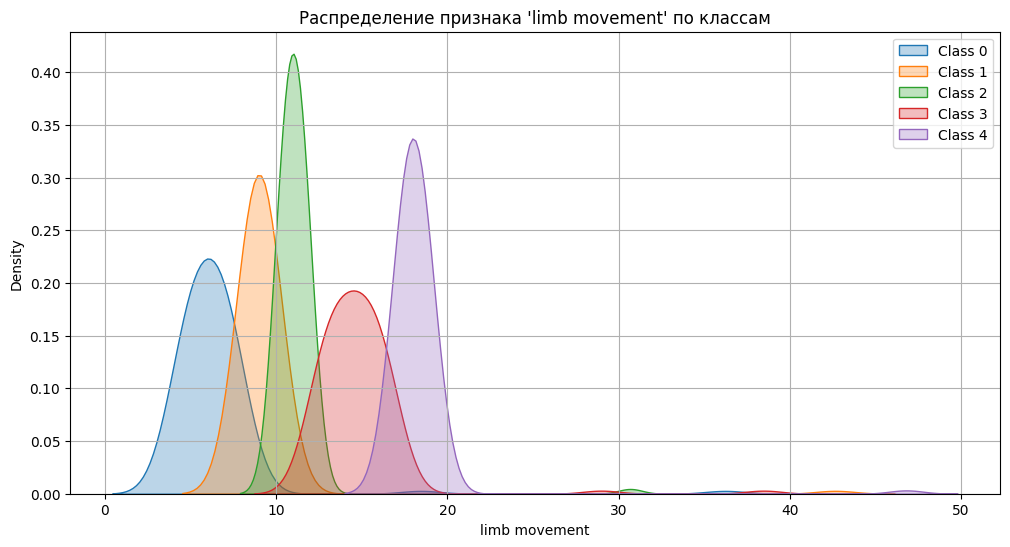


> Тест Шапиро–Уилка (нормальность по классам):
  Class 0: p = 0.0000 → Не нормальное
  Class 1: p = 0.0000 → Не нормальное
  Class 2: p = 0.0000 → Не нормальное
  Class 3: p = 0.0000 → Не нормальное
  Class 4: p = 0.0000 → Не нормальное

> Тест Колмогорова–Смирнова (сравнение распределений между классами):
  Class 0 vs 1: p = 0.0000 → Разные
  Class 0 vs 2: p = 0.0000 → Разные
  Class 0 vs 3: p = 0.0000 → Разные
  Class 0 vs 4: p = 0.0000 → Разные
  Class 1 vs 2: p = 0.0000 → Разные
  Class 1 vs 3: p = 0.0000 → Разные
  Class 1 vs 4: p = 0.0000 → Разные
  Class 2 vs 3: p = 0.0000 → Разные
  Class 2 vs 4: p = 0.0000 → Разные
  Class 3 vs 4: p = 0.0000 → Разные

> Тест Левена (проверка равенства дисперсий):
  Общий тест: p = 0.0151 → Дисперсии различаются

  Попарные сравнения дисперсий:
  0 vs 1: p = 0.1277 (скорр. = 1.0000) → Не различаются
  0 vs 2: p = 0.0254 (скорр. = 0.2539) → Не различаются
  0 vs 3: p = 0.5253 (скорр. = 1.0000) → Не различаются
  0 vs 4: p = 0.0831 (скорр. = 0.8

C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

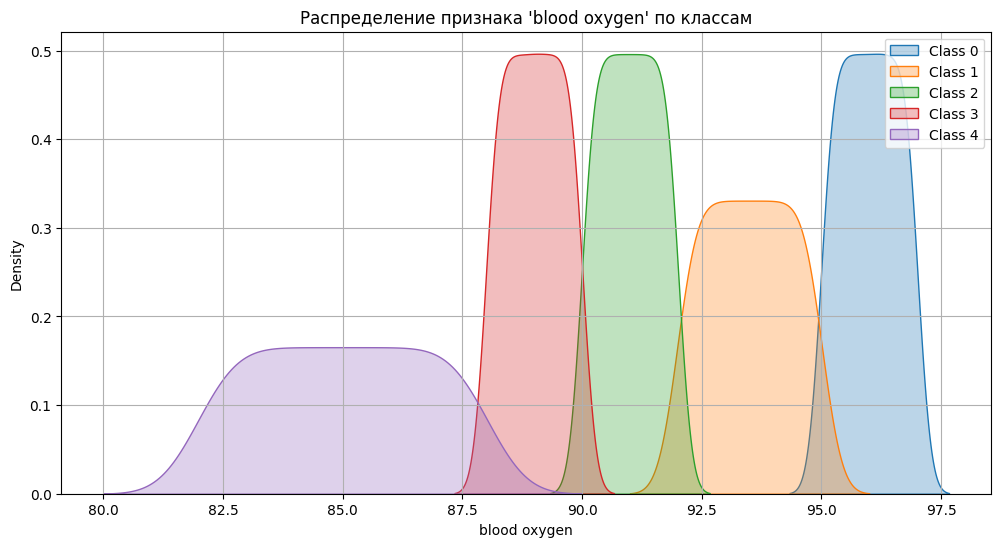


> Тест Шапиро–Уилка (нормальность по классам):
  Class 0: p = 0.0003 → Не нормальное
  Class 1: p = 0.0003 → Не нормальное
  Class 2: p = 0.0003 → Не нормальное
  Class 3: p = 0.0003 → Не нормальное
  Class 4: p = 0.0003 → Не нормальное

> Тест Колмогорова–Смирнова (сравнение распределений между классами):
  Class 0 vs 1: p = 0.0000 → Разные
  Class 0 vs 2: p = 0.0000 → Разные
  Class 0 vs 3: p = 0.0000 → Разные
  Class 0 vs 4: p = 0.0000 → Разные
  Class 1 vs 2: p = 0.0000 → Разные
  Class 1 vs 3: p = 0.0000 → Разные
  Class 1 vs 4: p = 0.0000 → Разные
  Class 2 vs 3: p = 0.0000 → Разные
  Class 2 vs 4: p = 0.0000 → Разные
  Class 3 vs 4: p = 0.0000 → Разные

> Тест Левена (проверка равенства дисперсий):
  Общий тест: p = 0.0000 → Дисперсии различаются

  Попарные сравнения дисперсий:
  0 vs 1: p = 0.0000 (скорр. = 0.0000) → Различаются
  0 vs 2: p = 0.9945 (скорр. = 1.0000) → Не различаются
  0 vs 3: p = 0.9982 (скорр. = 1.0000) → Не различаются
  0 vs 4: p = 0.0000 (скорр. = 0.0000

C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

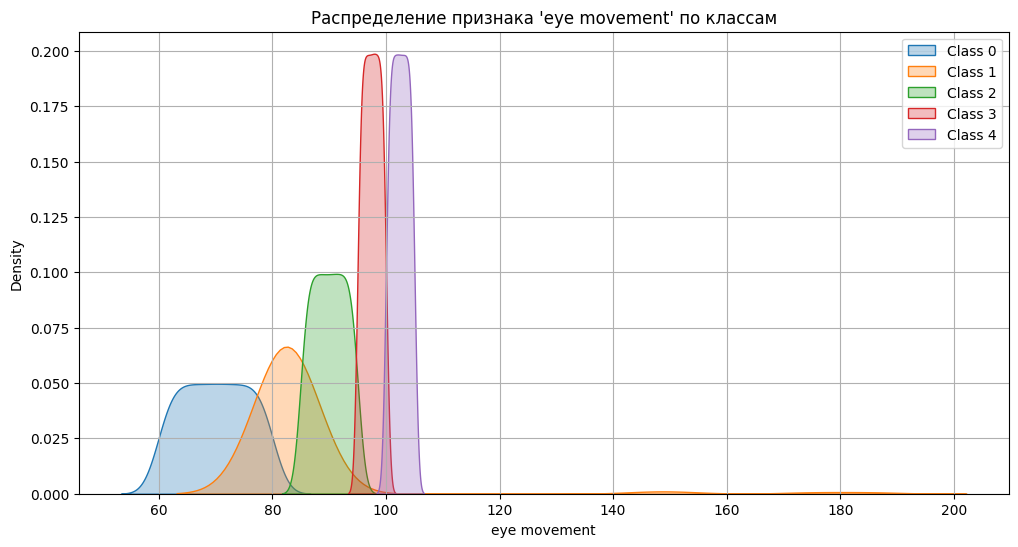


> Тест Шапиро–Уилка (нормальность по классам):
  Class 0: p = 0.0003 → Не нормальное
  Class 1: p = 0.0000 → Не нормальное
  Class 2: p = 0.0003 → Не нормальное
  Class 3: p = 0.0003 → Не нормальное
  Class 4: p = 0.0003 → Не нормальное

> Тест Колмогорова–Смирнова (сравнение распределений между классами):
  Class 0 vs 1: p = 0.0000 → Разные
  Class 0 vs 2: p = 0.0000 → Разные
  Class 0 vs 3: p = 0.0000 → Разные
  Class 0 vs 4: p = 0.0000 → Разные
  Class 1 vs 2: p = 0.0000 → Разные
  Class 1 vs 3: p = 0.0000 → Разные
  Class 1 vs 4: p = 0.0000 → Разные
  Class 2 vs 3: p = 0.0000 → Разные
  Class 2 vs 4: p = 0.0000 → Разные
  Class 3 vs 4: p = 0.0000 → Разные

> Тест Левена (проверка равенства дисперсий):
  Общий тест: p = 0.0000 → Дисперсии различаются

  Попарные сравнения дисперсий:
  0 vs 1: p = 0.3524 (скорр. = 1.0000) → Не различаются
  0 vs 2: p = 0.0000 (скорр. = 0.0000) → Различаются
  0 vs 3: p = 0.0000 (скорр. = 0.0000) → Различаются
  0 vs 4: p = 0.0000 (скорр. = 0.0000) →

C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

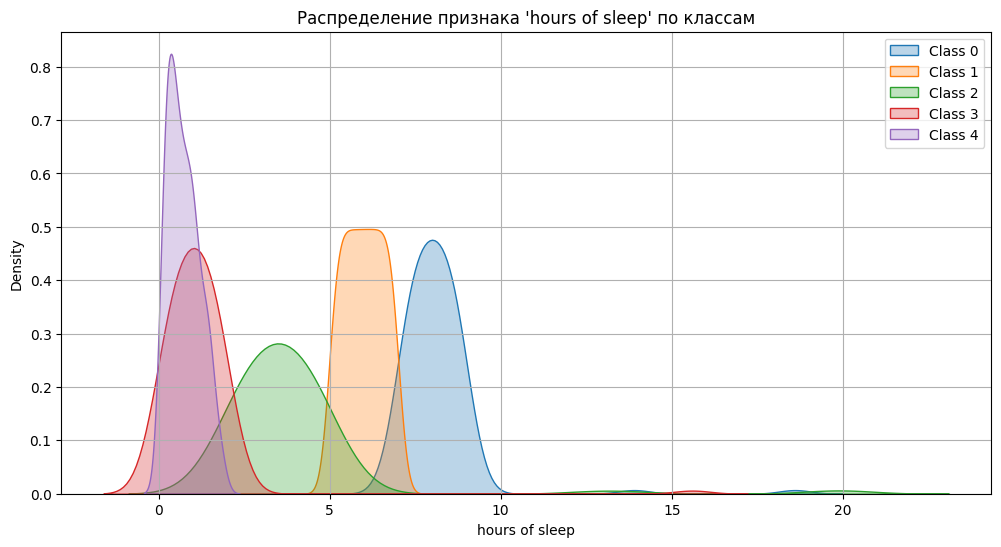


> Тест Шапиро–Уилка (нормальность по классам):
  Class 0: p = 0.0000 → Не нормальное
  Class 1: p = 0.0003 → Не нормальное
  Class 2: p = 0.0000 → Не нормальное
  Class 3: p = 0.0000 → Не нормальное
  Class 4: p = 0.0001 → Не нормальное

> Тест Колмогорова–Смирнова (сравнение распределений между классами):
  Class 0 vs 1: p = 0.0000 → Разные
  Class 0 vs 2: p = 0.0000 → Разные
  Class 0 vs 3: p = 0.0000 → Разные
  Class 0 vs 4: p = 0.0000 → Разные
  Class 1 vs 2: p = 0.0000 → Разные
  Class 1 vs 3: p = 0.0000 → Разные
  Class 1 vs 4: p = 0.0000 → Разные
  Class 2 vs 3: p = 0.0000 → Разные
  Class 2 vs 4: p = 0.0000 → Разные
  Class 3 vs 4: p = 0.0006 → Разные

> Тест Левена (проверка равенства дисперсий):
  Общий тест: p = 0.0000 → Дисперсии различаются

  Попарные сравнения дисперсий:
  0 vs 1: p = 0.2178 (скорр. = 1.0000) → Не различаются
  0 vs 2: p = 0.0190 (скорр. = 0.1901) → Не различаются
  0 vs 3: p = 0.9559 (скорр. = 1.0000) → Не различаются
  0 vs 4: p = 0.0131 (скорр. = 0.1

C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ela96\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

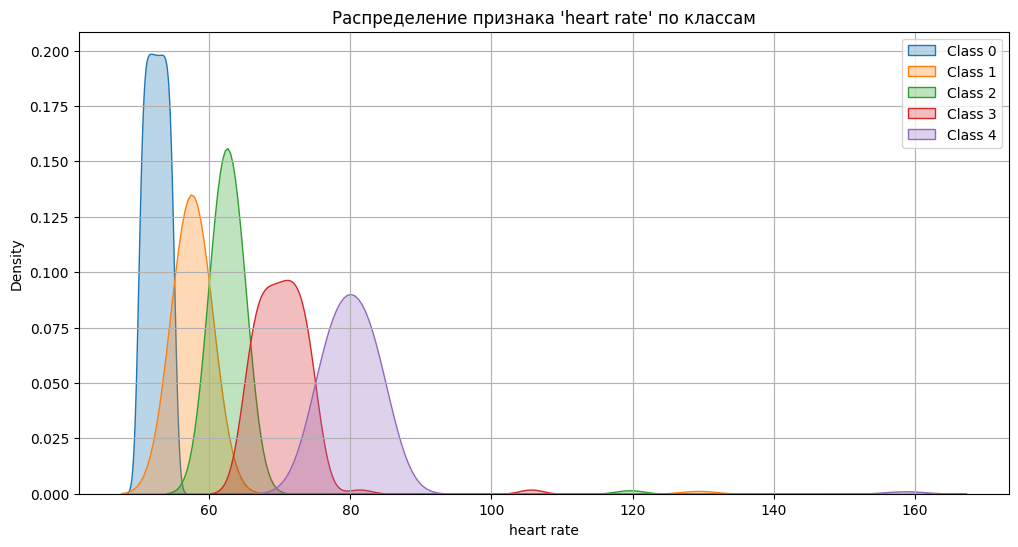


> Тест Шапиро–Уилка (нормальность по классам):
  Class 0: p = 0.0003 → Не нормальное
  Class 1: p = 0.0000 → Не нормальное
  Class 2: p = 0.0000 → Не нормальное
  Class 3: p = 0.0000 → Не нормальное
  Class 4: p = 0.0000 → Не нормальное

> Тест Колмогорова–Смирнова (сравнение распределений между классами):
  Class 0 vs 1: p = 0.0000 → Разные
  Class 0 vs 2: p = 0.0000 → Разные
  Class 0 vs 3: p = 0.0000 → Разные
  Class 0 vs 4: p = 0.0000 → Разные
  Class 1 vs 2: p = 0.0000 → Разные
  Class 1 vs 3: p = 0.0000 → Разные
  Class 1 vs 4: p = 0.0000 → Разные
  Class 2 vs 3: p = 0.0000 → Разные
  Class 2 vs 4: p = 0.0000 → Разные
  Class 3 vs 4: p = 0.0000 → Разные

> Тест Левена (проверка равенства дисперсий):
  Общий тест: p = 0.0112 → Дисперсии различаются

  Попарные сравнения дисперсий:
  0 vs 1: p = 0.3216 (скорр. = 1.0000) → Не различаются
  0 vs 2: p = 0.3387 (скорр. = 1.0000) → Не различаются
  0 vs 3: p = 0.0000 (скорр. = 0.0000) → Различаются
  0 vs 4: p = 0.0027 (скорр. = 0.0273

In [13]:
for feature in features:
    analyze_feature_distribution(data, feature)

Различия в дисперсиях могут указывать на:
разную степень вариативности стресса между группами,
неоднородность выборок,
наличие подгрупп внутри категорий стресса.

Дополнительно можно:

Исследовать почему некоторые классы имеют аномальную дисперсию (возможно, смешанные подгруппы).

Проверить нелинейные зависимости (например, U-образную связь со стрессом).

Использовать ансамблевые методы (типа RandomForest), так как они устойчивы к неравным дисперсиям.

Выводы:

1. Все признаки чувствительны к уровню стресса

Значения физиологических параметров меняются по мере роста стресса. Это делает все признаки ценными для предсказания уровня стресса.

2. Классы (уровни стресса) действительно различимы

Это говорит о том, что выбранная шкала уровней стресса имеет под собой статистическое обоснование — данные действительно группируются по уровням.

3. Можно формировать прогнозные модели

Результаты говорят в пользу использования признаков для построения моделей классификации по уровням стресса — признаки значимы и различимы.

ИТОГ:

Было установлено, что распределения физиологических показателей существенно различаются между уровнями стресса. При этом нормальность распределений не подтверждена, и различия в медианах между всеми парами классов статистически значимы. Это подтверждает достоверность выделения шкалы стресса и обоснованность дальнейшего использования признаков в моделировании.

Третья гипотеза проверяет влияние восстановления данных на статистику, чтобы понять искажает ли восстановление наши данные. Сравним оригинальный датасет с тремя вариантами восстановленных данных. 

Гипотеза 3:
H₀: Статистические параметры (среднее / дисперсия) не изменились после восстановления данных (не отличаются между
версиями датасетов).
H₁: Статистические параметры (среднее / дисперсия) изменились после восстановления данных (есть различия хотя бы
между двумя версиями датасетов).

In [7]:
from scipy.stats import ttest_ind, levene

In [16]:
df_main = pd.read_csv(r'C:\Users\ela96\Downloads\data_stress.csv')
df_vlad = pd.read_csv(r'C:\Users\ela96\Downloads\clear_data.csv', sep=';')
df_elena = pd.read_csv(r'C:\Users\ela96\ABD-PRJ-25-29\Checkpoint_2\data_filled.csv')
df_alex = pd.read_csv(r'C:\Users\ela96\Downloads\data_stress_updated.csv')

# Приведение всех названий колонок к единому виду
for df in [df_main, df_vlad, df_elena, df_alex]:
    df.columns = df.columns.str.strip().str.lower()

In [19]:
features = [
    'snoring range', 'respiration rate', 'body temperature',
    'limb movement', 'blood oxygen', 'eye movement',
    'hours of sleep', 'heart rate']

In [24]:
results = []

datasets = {
    "vlad": df_vlad,
    "elena": df_elena,
    "alex": df_alex
}

for name, df in datasets.items():
    for feature in features:
        x = df_main[feature].dropna()
        y = df[feature].dropna()

        # Используем U-тест вместо t-test, если данные не нормальные
        u_stat, p_u = mannwhitneyu(x, y, alternative='two-sided')

        # Levene's test (на гомогенность дисперсий)
        l_stat, p_levene = levene(x, y, center='mean')

        results.append({
            "сравнение": f"main vs {name}",
            "признак": feature,
            "p-value mann-whitney": p_u,
            "p-value levene": p_levene
        })

results_df = pd.DataFrame(results)

# Пример фильтра
display(results_df[results_df['сравнение'] == 'main vs vlad'])

,сравнение,признак,p-value mann-whitney,p-value levene
0,main vs vlad,snoring range,1.000000,1.000000
1,main vs vlad,respiration rate,0.914914,0.314729
2,main vs vlad,body temperature,0.634296,0.014340
3,main vs vlad,limb movement,0.793666,0.093239
4,main vs vlad,blood oxygen,0.937808,0.331504
5,main vs vlad,eye movement,0.844009,0.266877
6,main vs vlad,hours of sleep,0.054912,0.000495
7,main vs vlad,heart rate,0.888064,0.196510


В большинстве признаков (6 из 8) статистические параметры (медиана и дисперсия) не изменились после восстановления данных — это подтверждает корректность восстановления.

Исключения:

body temperature — статистически значимое изменение дисперсии, медиана осталась прежней.

hours of sleep — дисперсия изменилась существенно, а медиана находится на грани значимости (p ≈ 0.05), что требует внимания.

In [25]:
display(results_df[results_df['сравнение'] == 'main vs elena'])

,сравнение,признак,p-value mann-whitney,p-value levene
8,main vs elena,snoring range,1.000000,1.000000
9,main vs elena,respiration rate,1.000000,1.000000
10,main vs elena,body temperature,0.634633,0.015225
11,main vs elena,limb movement,0.925719,0.967340
12,main vs elena,blood oxygen,0.968291,0.344478
13,main vs elena,eye movement,0.939141,0.904446
14,main vs elena,hours of sleep,0.031792,0.101220
15,main vs elena,heart rate,0.978762,0.999002


В большинстве признаков (6 из 8) различий в медиане и дисперсии не выявлено — восстановление прошло корректно.

body temperature снова показывает изменение дисперсии (как и при сравнении с Vlad).

hours of sleep — есть статистически значимое различие по медиане, но дисперсия при этом осталась стабильной.

In [26]:
display(results_df[results_df['сравнение'] == 'main vs alex'])

,сравнение,признак,p-value mann-whitney,p-value levene
16,main vs alex,snoring range,1.000000,1.000000
17,main vs alex,respiration rate,1.000000,1.000000
18,main vs alex,body temperature,0.996033,0.014765
19,main vs alex,limb movement,1.000000,0.732159
20,main vs alex,blood oxygen,0.999814,0.365421
21,main vs alex,eye movement,1.000000,0.571140
22,main vs alex,hours of sleep,0.057562,0.059059
23,main vs alex,heart rate,1.000000,0.500528


Большинство признаков (6 из 8) не демонстрируют статистически значимых отличий ни по распределению, ни по дисперсии. Это говорит о хорошем качестве восстановления данных в этой версии.

body temperature:

Значимо отличается по дисперсии (p = 0.0148).

Распределения остаются схожими (медиана не изменилась).

hours of sleep:

Почти значимое отличие по медиане (p ≈ 0.0576) и дисперсии (p ≈ 0.0591).

Это может указывать на лёгкое смещение распределения (например, если были систематически заниженные/завышенные заполненные значения).

Вывод:
    
датасет df_alex — наиболее близкий к оригинальному (df_main) по следующим причинам:

Распределения (Mann–Whitney):

По всем признакам значения p > 0.05, т.е. нет статистически значимых отличий по медианам между main и alex.

Дисперсии (Levene):

Только один признак (body temperature) имеет статистически значимое отличие по дисперсии.

Остальные признаки — либо полностью совпадают, либо имеют незначимые расхождения (p > 0.05).